## Part B: Coding

In [1]:
pip install numpy opencv-python scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage.metrics import mean_squared_error
import math

Image shape: (225, 225, 3)


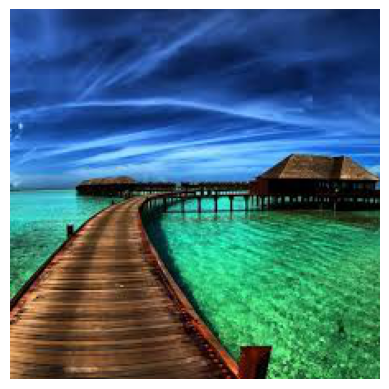

In [3]:
# Example Usage Image

from PIL import Image

# Load image using PIL
image_path = 'nature.png'
image = Image.open(image_path)

# Convert the image to a numpy array
image_array = np.array(image)

# Display the shape of the image
print("Image shape:", image_array.shape)

# Display the image
plt.imshow(image_array, cmap='gray')  # Use cmap='gray' for grayscale images
plt.axis('off')  # Hide axes
plt.show()

In [4]:
# Helper function to calculate Compression Ratio
def compression_ratio(original_size, compressed_size):
    return original_size / compressed_size

# Helper function to calculate RMSE
def rmse(original, reconstructed):
    return math.sqrt(mean_squared_error(original, reconstructed))

### A. Transform Coding (using DCT for forward transform)

In [5]:
def dct_encode(image):
    # Apply 2D DCT to the image
    transformed_image = dct(dct(image.T, norm='ortho').T, norm='ortho')
    return transformed_image

def dct_decode(transformed_image):
    # Apply 2D Inverse DCT to the image
    reconstructed_image = idct(idct(transformed_image.T, norm='ortho').T, norm='ortho')
    return reconstructed_image

# Example Usage
original_image = cv2.imread('nature.png', cv2.IMREAD_GRAYSCALE)
transformed_image = dct_encode(original_image)
reconstructed_image = dct_decode(transformed_image)

# Calculate Compression Ratio (Example)
compressed_size = np.count_nonzero(transformed_image) * transformed_image.itemsize
original_size = original_image.size * original_image.itemsize
print("Compression Ratio:", compression_ratio(original_size, compressed_size))

# Calculate RMSE
print("RMSE:", rmse(original_image, reconstructed_image))

Compression Ratio: 0.125
RMSE: 3.759847506248309e-14


### B. Huffman Encoding

In [6]:
import heapq
from collections import defaultdict

def calculate_frequency(data):
    freq = defaultdict(int)
    for pixel in data.flatten():
        freq[pixel] += 1
    return freq

def huffman_encode(image):
    # Flatten the image and calculate frequency
    freq = calculate_frequency(image)
    
    # Build Huffman Tree
    heap = [[weight, [symbol, '']] for symbol, weight in freq.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    huff_dict = dict(sorted(heap[0][1:], key=lambda p: (len(p[-1]), p)))
    
    # Encode image
    encoded_image = ''.join(huff_dict[pixel] for pixel in image.flatten())
    return encoded_image, huff_dict

def huffman_decode(encoded_image, huff_dict, shape):
    # Decode image using Huffman dictionary
    reverse_dict = {v: k for k, v in huff_dict.items()}
    current_code = ''
    decoded_pixels = []
    for bit in encoded_image:
        current_code += bit
        if current_code in reverse_dict:
            decoded_pixels.append(reverse_dict[current_code])
            current_code = ''
    decoded_image = np.array(decoded_pixels).reshape(shape)
    return decoded_image

# Huffman Encoding Example Usage
original_image = cv2.imread('nature.png', cv2.IMREAD_GRAYSCALE)
encoded_image, huffman_dict = huffman_encode(original_image)
reconstructed_image = huffman_decode(encoded_image, huffman_dict, original_image.shape)

# Calculate Compression Ratio for Huffman Encoding
compressed_size = len(encoded_image) // 8  # Converting bit-length to byte size
original_size = original_image.size * original_image.itemsize
print("Huffman Compression Ratio:", compression_ratio(original_size, compressed_size))

# Calculate RMSE
print("Huffman RMSE:", rmse(original_image, reconstructed_image))

Huffman Compression Ratio: 1.0743389499596792
Huffman RMSE: 0.0


### C. LZW Encoding

In [7]:
def lzw_encode(image):
    # Convert the image to a list of bytes
    data = image.flatten().tolist()
    
    # Initialize dictionary with single symbols
    dictionary = {bytes([i]): i for i in range(256)}
    encoded_data = []
    w = b""
    
    for c in data:
        wc = w + bytes([c])
        if wc in dictionary:
            w = wc
        else:
            encoded_data.append(dictionary[w])
            dictionary[wc] = len(dictionary)
            w = bytes([c])
    if w:
        encoded_data.append(dictionary[w])
    return encoded_data

def lzw_decode(encoded_data):
    # Reverse the encoding dictionary
    dictionary = {i: bytes([i]) for i in range(256)}
    w = bytes([encoded_data.pop(0)])
    decoded_data = [w]
    
    for k in encoded_data:
        entry = dictionary.get(k, w + w[:1])
        decoded_data.append(entry)
        dictionary[len(dictionary)] = w + entry[:1]
        w = entry
    return np.array([pixel for byte in decoded_data for pixel in byte])

# LZW Encoding Example Usage
original_image = cv2.imread('nature.png', cv2.IMREAD_GRAYSCALE)
encoded_data = lzw_encode(original_image)
reconstructed_image = lzw_decode(encoded_data).reshape(original_image.shape)

# Calculate Compression Ratio for LZW Encoding
compressed_size = len(encoded_data) * 4  # Assuming 32-bit integers in encoded data
original_size = original_image.size * original_image.itemsize
print("LZW Compression Ratio:", compression_ratio(original_size, compressed_size))

# Calculate RMSE
print("LZW RMSE:", rmse(original_image, reconstructed_image))

LZW Compression Ratio: 0.4798942099874872
LZW RMSE: 0.0


### D. Run-Length Encoding

In [8]:
def rle_encode(image):
    pixels = image.flatten()
    encoded_data = []
    last_pixel = pixels[0]
    count = 1
    for pixel in pixels[1:]:
        if pixel == last_pixel:
            count += 1
        else:
            encoded_data.append((last_pixel, count))
            last_pixel = pixel
            count = 1
    encoded_data.append((last_pixel, count))
    return encoded_data

def rle_decode(encoded_data, shape):
    decoded_image = []
    for pixel, count in encoded_data:
        decoded_image.extend([pixel] * count)
    return np.array(decoded_image).reshape(shape)

# RLE Encoding Example Usage
original_image = cv2.imread('nature.png', cv2.IMREAD_GRAYSCALE)
encoded_data = rle_encode(original_image)
reconstructed_image = rle_decode(encoded_data, original_image.shape)

# Calculate Compression Ratio for RLE Encoding
compressed_size = len(encoded_data) * 2  # Each (pixel, count) pair typically uses 2 bytes
original_size = original_image.size * original_image.itemsize
print("RLE Compression Ratio:", compression_ratio(original_size, compressed_size))

# Calculate RMSE
print("RLE RMSE:", rmse(original_image, reconstructed_image))

RLE Compression Ratio: 0.5954201166729394
RLE RMSE: 0.0


### E. Arithmetic Coding

In [9]:
import numpy as np
from PIL import Image
import math

In [10]:
def calculate_frequencies(image):
    frequencies = np.zeros(256)  # For 8-bit grayscale image
    for pixel in image.ravel():
        frequencies[pixel] += 1
    return frequencies / np.sum(frequencies)

def arithmetic_encode(image, frequencies):
    low, high = 0.0, 1.0
    cumulative_freq = np.cumsum(frequencies)
    
    for pixel in image.ravel():
        range_width = high - low
        high = low + range_width * cumulative_freq[pixel]
        low = low + range_width * cumulative_freq[pixel - 1] if pixel > 0 else low
    
    return (low + high) / 2

def arithmetic_decode(encoded_value, shape, frequencies):
    image = np.zeros(shape, dtype=np.uint8)
    low, high = 0.0, 1.0
    cumulative_freq = np.cumsum(frequencies)
    
    for i in range(shape[0] * shape[1]):
        range_width = high - low
        # Find the decoded pixel value within bounds
        decoded_pixel = np.searchsorted(cumulative_freq, (encoded_value - low) / range_width)
        decoded_pixel = min(decoded_pixel, 255)  # Ensure index is within [0, 255]
        
        image.ravel()[i] = decoded_pixel
        high = low + range_width * cumulative_freq[decoded_pixel]
        low = low + range_width * cumulative_freq[decoded_pixel - 1] if decoded_pixel > 0 else low
    
    return image

def compression_ratio(original_image, encoded_value):
    original_size = original_image.size * 8  # Each pixel as 8 bits
    encoded_size = math.ceil(-math.log2(encoded_value))  # Bits to represent the code
    return original_size / encoded_size

def rmse(original_image, reconstructed_image):
    return np.sqrt(np.mean((original_image - reconstructed_image) ** 2))

def arithmetic_coding_workflow(image_path):
    # Load and convert image to grayscale
    original_image = np.array(Image.open(image_path).convert('L'))
    
    # Step 1: Calculate frequencies
    frequencies = calculate_frequencies(original_image)
    
    # Step 2: Encode the image
    encoded_value = arithmetic_encode(original_image, frequencies)
    
    # Step 3: Decode the image
    reconstructed_image = arithmetic_decode(encoded_value, original_image.shape, frequencies)
    
    # Step 4: Calculate compression ratio
    comp_ratio = compression_ratio(original_image, encoded_value)
    
    # Step 5: Calculate RMSE
    rmse_value = rmse(original_image, reconstructed_image)
    
    return comp_ratio, rmse_value, reconstructed_image

# Arithmetic Encoding Example Usage
image_path = 'nature.png'
comp_ratio, rmse_value, reconstructed_image = arithmetic_coding_workflow(image_path)

print("Arithmetic Compression Ratio:", comp_ratio)
print("Arithmetic RMSE:", rmse_value)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17216\334534403.py:26: RuntimeWarning: invalid value encountered in double_scalars
  decoded_pixel = np.searchsorted(cumulative_freq, (encoded_value - low) / range_width)


Arithmetic Compression Ratio: 405000.0
Arithmetic RMSE: 10.32809329504295
